In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import LeakyReLU
import matplotlib.pyplot as plt
from rnnconv import RnnConv

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
(train_images2, train_labels2), (test_images2, test_labels2) = datasets.cifar100.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images2, test_iamges2 = train_images2 / 255.0, test_images / 255.0

train_images = np.concatenate((train_images, train_images2) ,axis=0)
test_images = np.concatenate((test_images, test_images2), axis=0)

train_labels = np.concatenate((train_labels, train_labels2), axis=0)
test_labels = np.concatenate((test_labels, test_labels2), axis=0)

In [2]:
print(tf.config.list_physical_devices("GPU"))
iterations = 1

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
model = tf.keras.Sequential() 
relu_amount = 1e-6

for i in range(iterations):

    model.add(layers.Conv2D(filters=64, kernel_size=3, input_shape=(32, 32, 3), strides = (2, 2), padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))

    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=256, kernel_size=3, strides=(2, 2),   padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))
    
    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=512, kernel_size=3, strides=(2, 2),   padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))
    
    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=512, kernel_size=3, strides=(2, 2),   padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))

    model.add(layers.Conv2D(filters=32, kernel_size=1,  strides = (1,1), padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))

    model.add(layers.Conv2D(filters=512, kernel_size=1,  strides = (1,1), padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))
    
    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=512, kernel_size=2, strides=(1, 1), padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))
    model.add(layers.Lambda(lambda x:tf.nn.depth_to_space(x,2,data_format='NHWC')))

    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=512, kernel_size=3, strides=(1, 1), padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))
    model.add(layers.Lambda(lambda x:tf.nn.depth_to_space(x,2,data_format='NHWC')))
    
    
    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))
    model.add(layers.Lambda(lambda x:tf.nn.depth_to_space(x,2,data_format='NHWC')))

    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))
    model.add(layers.Lambda(lambda x:tf.nn.depth_to_space(x,2,data_format='NHWC')))

    model.add(layers.Conv2D(filters=3, kernel_size=1, strides = (1,1), padding='same', data_format='channels_last'))
    model.add(LeakyReLU(alpha=relu_amount))

In [4]:

opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.9, epsilon=1e-06, amsgrad=True)

def SSIMLoss(y_true, y_pred):
    return tf.math.square(1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0)))

model.compile(optimizer=opt, loss=SSIMLoss, metrics=[SSIMLoss])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
lambda (Lambda)              (None, 1, 16, 16, 64)     0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 8, 8, 256)         2950144   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1, 8, 8, 256)      0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 4, 4, 512)         1

In [5]:
from skimage.util import random_noise

# noisy_image = random_noise(train_images, mode="s&p", amount=0.01)
# validation_data = (train_images[0:1000,:,:,:],train_images[0:1000,:,:,:])

In [6]:
train_images_ = tf.convert_to_tensor(train_images.reshape((-1,3,32,32)))

# reshaped_images = tf.expand_dims(train_images, axis=1)
model3 = model.fit(train_images, train_images, batch_size=64, epochs=20, validation_split=0.1)

Epoch 1/20
1407/1407 [==============================] - 236s 168ms/step - loss: 0.2371 - SSIMLoss: 0.2371 - val_loss: 0.1188 - val_SSIMLoss: 0.1188
Epoch 2/20
1407/1407 [==============================] - 232s 165ms/step - loss: 0.0887 - SSIMLoss: 0.0887 - val_loss: 0.0697 - val_SSIMLoss: 0.0698
Epoch 3/20
1407/1407 [==============================] - 230s 163ms/step - loss: 0.0574 - SSIMLoss: 0.0574 - val_loss: 0.0538 - val_SSIMLoss: 0.0539
Epoch 4/20
1407/1407 [==============================] - 229s 162ms/step - loss: 0.0443 - SSIMLoss: 0.0443 - val_loss: 0.0444 - val_SSIMLoss: 0.0445
Epoch 5/20
1407/1407 [==============================] - 228s 162ms/step - loss: 0.0364 - SSIMLoss: 0.0364 - val_loss: 0.0365 - val_SSIMLoss: 0.0365
Epoch 6/20
1407/1407 [==============================] - 228s 162ms/step - loss: 0.0316 - SSIMLoss: 0.0316 - val_loss: 0.0336 - val_SSIMLoss: 0.0337
Epoch 7/20
1407/1407 [==============================] - 228s 162ms/step - loss: 0.0287 - SSIMLoss: 0.0286 - val_

In [7]:
tf.expand_dims(train_images, axis=1).shape

TensorShape([100000, 1, 32, 32, 3])

(32, 32, 3)


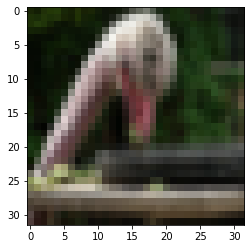

In [8]:
from matplotlib import pyplot as plt

img = train_images_[400]
img_ = img.numpy().reshape((32,32,3))
plt.imshow(img_, interpolation='nearest')
print(img_.shape)
plt.show()

In [9]:
# img_pred = test_images[0:10].reshape((10,3,32,32,))
full = model.predict(test_images[0:10,:,:,:])

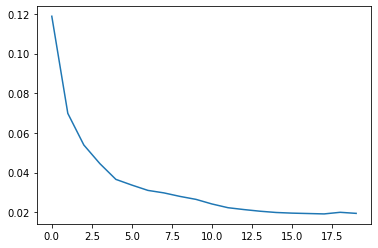

In [10]:
plt.plot(model3.history["val_SSIMLoss"])

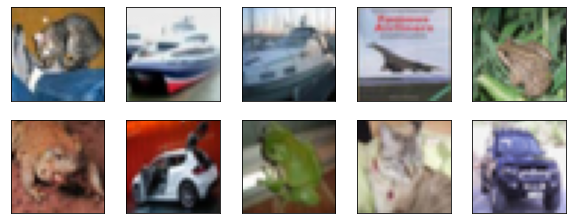

In [11]:
# img_pred_full= img_pred.reshape((10,32,32,3))

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[0:10,:,:,:][i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


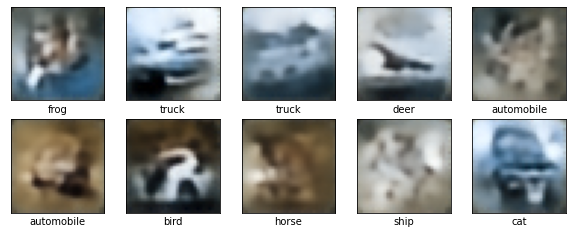

In [12]:
full_pred = full.reshape((10,32,32,3))

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(full_pred[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [13]:
full_pred[0]

array([[[0.24686791, 0.25120077, 0.23827502],
        [0.34713316, 0.36771363, 0.32560602],
        [0.36529475, 0.38732213, 0.38411656],
        ...,
        [0.19367829, 0.21253563, 0.21174365],
        [0.23759696, 0.24458894, 0.22461483],
        [0.23357117, 0.23640716, 0.20925239]],

       [[0.27586558, 0.2952224 , 0.29113322],
        [0.35718426, 0.37600887, 0.34464395],
        [0.35080305, 0.3747396 , 0.3617572 ],
        ...,
        [0.1819937 , 0.20115517, 0.19338003],
        [0.22836767, 0.25152278, 0.22876471],
        [0.25641733, 0.26108402, 0.21850827]],

       [[0.35790494, 0.37931472, 0.36045572],
        [0.3341709 , 0.3686728 , 0.36134332],
        [0.3408408 , 0.3776858 , 0.3667837 ],
        ...,
        [0.18653995, 0.20577557, 0.19345912],
        [0.21644944, 0.24438673, 0.2344557 ],
        [0.22504844, 0.25489527, 0.23828357]],

       ...,

       [[0.35515094, 0.41934723, 0.44037902],
        [0.32246593, 0.4196068 , 0.4667825 ],
        [0.2902447 , 0

In [14]:
import numpy as np
image_number = np.random.randint(low=0, high=train_images.shape[0], size=1)[0]

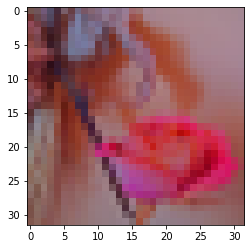

In [15]:
plt.imshow(train_images[image_number])

In [ ]:
pip install awscli
aws s3 --no-sign-request sync s3://open-images-dataset/challenge2018 ./test_challenge_2018

In [16]:
train_images[image_number].shape

(32, 32, 3)